# Applied Programming Lab: Week 4 Submission
**by Niranjan A. Kartha (EE21B095)**

____

# Importing Libraries

In [1]:
import networkx as nx
import timeit
import collections

____

# Loading the dataset

We can construct the graph as we read the text file.

First we can declare the name of the circuit to use:

In [2]:
circuit_name = "c8"

Now we parse the lines into a directed graph:

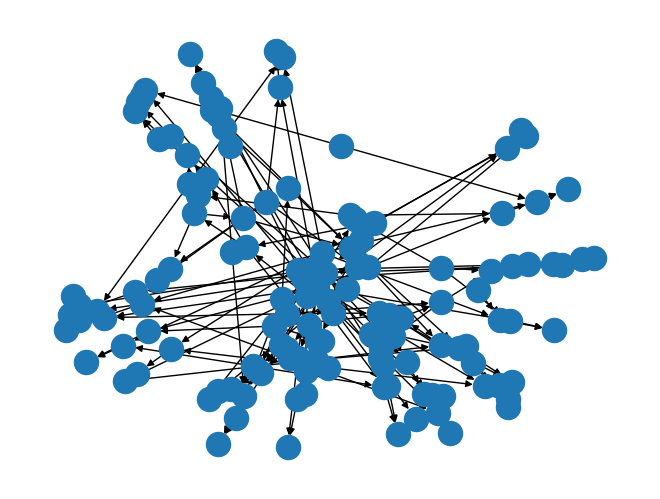

In [3]:
def get_graph(filename):
    """
    Creates a directed acyclic graph based on the netlist specified in a
    file. Returns the graph and a dict corresponding to all the nets.
    """
    
    g = nx.DiGraph()
    
    edges = [] # all the edges of the graph
    attributes = {} # gate types
    state = {}
    
    lines = open(filename, "r").readlines()

    for line in lines:
        tokens = line.split()
        
        already_defined = False # whether this net has already been defined
                                # to be the output of a gate
        
        op = tokens[1].upper() # operator name
        
        if len(tokens) == 0:
            continue
            
        if len(tokens) < 4:
            raise Error(f"too few tokens:\n{line}")
            
        # now validate the different types of gates and add them to our
        # graph:
        if op in ["AND2", "OR2", "NOR2", "NAND2", "XOR2", "XNOR2"]:
            if len(tokens) != 5:
                raise Exception(f"wrong number of tokens:\n{line}")
                
            if tokens[4] in attributes:
                already_defined = True
            else:
                edges.append((tokens[2], tokens[4]))
                edges.append((tokens[3], tokens[4]))
                attributes[tokens[4]] = op
                
                state[tokens[2]] = None
                state[tokens[3]] = None
                state[tokens[4]] = None
                
        elif op in ["NOT", "INV", "BUF"]:
            if len(tokens) != 4:
                raise Exception(f"wrong number of tokens:\n{line}")
            
            if tokens[3] in attributes:
                already_defined = True
            else:
                edges.append((tokens[2], tokens[3]))
                attributes[tokens[3]] = op
                
                state[tokens[2]] = None
                state[tokens[3]] = None
        else:
            # if gate_type is not specified we take it as an AND gate
            
            if len(tokens) != 4:
                raise Exception(f"wrong number of tokens:\n{line}")
                
            if tokens[3] in attributes:
                already_defined = True
            else:
                edges.append((tokens[1], tokens[3]))
                edges.append((tokens[2], tokens[3]))
                attributes[tokens[3]] = "AND2"
                
                state[tokens[1]] = None
                state[tokens[2]] = None
                state[tokens[3]] = None
        
        if already_defined:
            raise Exception(f"redefinition of net:\n{line}")
            
    g.add_edges_from(edges)
    nx.set_node_attributes(g, attributes, name="gateType")
    
    if not nx.is_directed_acyclic_graph(g):
        raise Exception("given circuit is cyclic")
    
    return (g, state)

(dag, state) = get_graph(f"benchmarks/{circuit_name}.net")
nx.draw(dag)

We also define a convenience function that returns the value of a boolean operation given its string name and its operands.

In [4]:
def evaluate_gate(gate_type, args):
    """Evaluate a gate given its type and arguments"""
    
    val = None
    
    if gate_type == "AND2":
        val = args[0] and args[1]
        
    elif gate_type == "OR2":
        val = args[0] or args[1]
        
    elif gate_type == "NOR2":
        val = not (args[0] or args[1])
        
    elif gate_type == "NAND2":
        val = not (args[0] and args[1])
        
    elif gate_type == "XOR2":
        val = args[0] ^ args[1]
        
    elif gate_type == "XNOR2":
        val = not (args[0] ^ args[1])
        
    elif gate_type in ["NOT", "INV"]:
        val = not args[0]
        
    else:
        val = args[0]

    return val

____

# Topologically ordered evaluation

One way to evaluate a given net is through topological sorting.

In [5]:
nl = list(nx.topological_sort(dag))
print(nl)

['q', 'h', 'g', 'f', 'bn0', 'e', 'an0', 'd', 'r', 'cn0', 'y', 'z', 'c', 'b', 'a', 'v', 'w', 'x', 'i', 'l', 'k', 'm', 'n', 'j', 'p', 'u', 'o', 's', 'n_1', 'n_0', 'dummy_11', 'dummy_32', 'dummy_37', 'n_20', 'ln0', 'dummy_28', 'dummy_12', 'dummy_30', 'n_43', 'dummy_39', 'n_2', 'dummy_21', 'dummy_26', 'dummy_24', 'n_31', 'dummy_34', 'dummy_36', 'n_5', 'n_16', 'n_60', 'n_7', 'dummy_25', 'dummy_27', 'dummy_29', 'dummy_31', 'dummy_33', 'dummy_35', 'dummy_38', 'dummy_40', 'dummy_23', 'n_6', 'n_25', 'n_23', 'n_17', 'n_14', 'n_12', 'n_11', 'n_10', 'n_9', 'n_8', 'dummy_1', 'dummy_3', 'dummy_5', 'dummy_7', 'dummy_10', 'dummy_15', 'dummy_18', 'dummy_20', 'dummy_22', 'gn0', 'fn0', 'hn0', 'in0', 'kn0', 'dn0', 'jn0', 'en0', 'n_24', 'n_27', 'n_26', 'n_32', 'n_28', 'dummy_19', 'dummy_17', 'dummy_16', 'n_35', 'n_30', 'n_33', 'n_29', 'n_34', 'n_37', 'n_36', 'n_44', 'dummy_14', 'dummy_13', 'mn0', 'nn0', 'dummy_9', 'dummy_8', 'n_48', 'n_42', 'n_39', 'n_40', 'n_47', 'n_50', 'n_49', 'n_54', 'dummy_6', 'on0', 

Below is the function that evaluates a circuit given its topologically sorted node list.

In [6]:
def evaluate_topo(g, sorted_node_list, input_names, input_values, state):
    """
    Evaluate a circuit in topological order given its DAG and topo-sorted
    node-list. The output is stored in `state`.
    """
    
    # set inputs
    for i in range(len(input_names)):
        state[input_names[i]] = (input_values[i] == "1")
    
    gate_types = nx.get_node_attributes(g, "gateType")
    
    # evaluate the rest of the nets
    for i in range(len(input_names), len(sorted_node_list)):
        node = sorted_node_list[i]
        args = [state[p] for p in g.predecessors(node)]
        state[node] = evaluate_gate(gate_types[node], args)

In [7]:
# read input names
input_lines = open(f"benchmarks/{circuit_name}.inputs", "r").readlines()
input_names = input_lines[0].split()

# prepare output file
state_list = sorted(state)
outfile = open(f"benchmarks/{circuit_name}.out-topo", "w")
outfile.write(" ".join(state_list))
outfile.write("\n")

# evaluate inputs
for i in range(1, len(input_lines)):
    split = input_lines[i].split()
    
    evaluate_topo(dag, nl, input_names, split, state)
    
    outfile.write(
        " ".join(
            [str(int(state[name])) for name in state_list]
        )
    )
    outfile.write("\n")
    outfile.flush()

____

# Event-driven evaluation

We can evaluate node-lists with a queue as follows:

In [8]:
(dag, state) = get_graph(f"benchmarks/{circuit_name}.net")

In [9]:
def evaluate_queued(g, input_names, input_values, state):
    """
    Evaluate a circuit in an event-driven manner given its DAG. The output
    is stored in `state`.
    """
    
    # create a queue
    q = collections.deque()
    
    gate_types = nx.get_node_attributes(g, "gateType")
    
    # look for inputs that changed, and append their successors to the queue
    for i in range(len(input_names)):
        val = (input_values[i] == "1")
        
        if state[input_names[i]] != val:
            state[input_names[i]] = val
            
            q.extend(g.successors(input_names[i]))
    
    # while the queue is not empty, evaluate
    while q:
        node = q.popleft()
        args = []
        
        # if any of the arguments of the node has not been evaluated yet,
        # don't evaluate it - it will be evaluated after that node is done
        is_none = False
        
        for p in g.predecessors(node):
            if state[p] is None:
                is_none = True
                break
            args.append(state[p])
        
        if is_none:
            continue

        new_val = evaluate_gate(gate_types[node], args)
        
        # if the state has changed, add the successors to the queue
        if state[node] != new_val:
            state[node] = new_val
            # for succ in g.successors(node):
            #     if succ not in q:
            #         q.append(succ)
            q.extend(g.successors(node))

In [10]:
# read input names
input_lines = open(f"benchmarks/{circuit_name}.inputs", "r").readlines()
input_names = input_lines[0].split()

# prepare output file
state_list = sorted(state)
outfile = open(f"benchmarks/{circuit_name}.out-topo", "w")
outfile.write(" ".join(state_list))
outfile.write("\n")

# evaluate inputs
for i in range(1, len(input_lines)):
    split = input_lines[i].split()
            
    evaluate_queued(dag, input_names, split, state)
    
    outfile.write(
        " ".join(
            [str(int(state[name])) for name in state_list]
        )
    )
    outfile.write("\n")
    outfile.flush()

____

# Benchmarks

We can see how fast each method is for

1. Single input
2. Multiple (changing) inputs

And also for

1. Small circuits
2. Large circuits

## Single input

### On a large circuit

In [11]:
# read one input line
input_lines = open(f"benchmarks/c432.inputs", "r").readlines()
input_names = input_lines[0].split()
split = input_lines[1].split()

(dag, state) = get_graph("benchmarks/c432.net")

def reset_state():
    """
    Reset the state dictionary because we do not want the event-driven
    evaluation to work based on old values when we do not want it to.
    """
    
    for s in state:
        state[s] = None

def topo_bench_single():
    reset_state() # this does not do much here but we put this here to
                  # compare timings with the event-driven method
    
    nl = list(nx.topological_sort(dag))
    evaluate_topo(dag, nl, input_names, split, state)

def queued_bench_single():
    reset_state()
    evaluate_queued(dag, input_names, split, state)

In [12]:
%timeit topo_bench_single()

460 µs ± 27.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
%timeit queued_bench_single()

385 µs ± 20 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### On a small circuit

In [14]:
input_lines = open(f"benchmarks/c17.inputs", "r").readlines()
input_names = input_lines[0].split()

split = input_lines[1].split()

(dag, state) = get_graph("benchmarks/c17.net")

In [15]:
%timeit topo_bench_single()

27.4 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [16]:
%timeit queued_bench_single()

18.4 µs ± 82.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Observation

We can see that both methods give comparable results. In the above cases, event-driven evaluation has outperformed topologically ordered evaluation because it avoids the topological sort.

## Multiple inputs on a large circuit

In [17]:
test_count = 100
input_lines = open(f"benchmarks/c432.inputs", "r").readlines()
input_names = input_lines[0].split()

(dag, state) = get_graph("benchmarks/c432.net")

def topo_bench_multiple():
    reset_state()
    
    nl = list(nx.topological_sort(dag))
    
    for i in range(1, test_count):
        split = input_lines[i].split()
        evaluate_topo(dag, nl, input_names, split, state)

def queued_bench_multiple():
    reset_state()
    
    for i in range(1, test_count):
        split = input_lines[i].split()
        evaluate_queued(dag, input_names, split, state)

In [18]:
%timeit topo_bench_multiple()

21.6 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%timeit queued_bench_multiple()

29.6 ms ± 1.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Multiple inputs on a small circuit

In [22]:
test_count = 10
input_lines = open(f"benchmarks/c17.inputs", "r").readlines()
input_names = input_lines[0].split()

(dag, state) = get_graph("benchmarks/c17.net")

In [23]:
%timeit topo_bench_multiple()

112 µs ± 844 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [24]:
%timeit queued_bench_multiple()

114 µs ± 887 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Observation

Again, both methods give similar performances. The event-driven method sometimes would perform better (because it does not have to re-evaluate the whole circuit) and sometimes perform worse (because it sometimes evaluates nets multiple times unnecessarily).

____

# Reasoning behind the benchmarks

In order to analyze why the performance is the way it is, we can count the number of gate evaluations by modifying the evaluation function:

In [25]:
num_eval = 0

def evaluate_gate(gate_type, args):
    """Evaluate a gate given its type and arguments"""
    global num_eval
    
    # count the number of times this function has been called
    num_eval += 1
    val = None
    
    if gate_type == "AND2":
        val = args[0] and args[1]
        
    elif gate_type == "OR2":
        val = args[0] or args[1]
        
    elif gate_type == "NOR2":
        val = not (args[0] or args[1])
        
    elif gate_type == "NAND2":
        val = not (args[0] and args[1])
        
    elif gate_type == "XOR2":
        val = args[0] ^ args[1]
        
    elif gate_type == "XNOR2":
        val = not (args[0] ^ args[1])
        
    elif gate_type in ["NOT", "INV"]:
        val = not args[0]
        
    else:
        val = args[0]

    return val

In [26]:
input_lines = open(f"benchmarks/c432.inputs", "r").readlines()
input_names = input_lines[0].split()

topo_nums = []
queued_nums = []

(dag, state) = get_graph("benchmarks/c432.net")
    
topo_nums = []

nl = list(nx.topological_sort(dag))

for i in range(1, len(input_lines)):
    split = input_lines[i].split()

    num_eval = 0
    evaluate_topo(dag, nl, input_names, split, state)
    topo_nums.append(num_eval)

print("topological evaluation takes", sum(topo_nums) / len(topo_nums),
      "gate evaluations on average\n")
print("array:", topo_nums)

reset_state()

queued_nums = []
(dag, state) = get_graph("benchmarks/c432.net")

for i in range(1, len(input_lines)):
    split = input_lines[i].split()

    num_eval = 0
    evaluate_queued(dag, input_names, split, state)
    queued_nums.append(num_eval)

print("\n")
print("event-driven evaluation takes", sum(queued_nums) / len(queued_nums),
      "gate evaluations on average\n")
print("array:", queued_nums)

topological evaluation takes 183.0 gate evaluations on average

array: [183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183]


event-driven evaluation takes 207.42 gate evaluations on average

array: [209, 132, 345, 220, 321, 254, 231, 200, 292, 181, 152, 193, 188, 193, 145, 109, 210, 197, 159, 114, 224, 239, 95, 269, 301, 252, 226, 202, 95, 199, 165, 195, 146, 220, 186, 146, 209, 298, 243, 293, 246, 129, 70, 187, 279, 161, 252, 508, 197, 96, 225, 365, 271, 234, 212, 322, 287, 173, 201, 253, 185, 64, 189, 226, 298, 101, 142, 235, 155, 105, 239, 17

As we can see above, topologically ordered evaluation performs the same number of gate evaluations for every different input that we give it, while for event-driven evaluation, the number of gate evaluations depends on the number of inputs changed, and the layout of the circuit.

Since most of the inputs change from one line to the next in our test cases, event-driven evaluation does not give us much of an advantage, and instead underperforms. So, assuming that most values change between inputs, topologically ordered evaluation generally performs better for a larger number of inputs.

## Which method is faster?

1. Generally, the lower the [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) between inputs, the better event-driven evaluation will perform. If we have a large number of randomly varying inputs, then toplogically ordered evaluation is better.
    
2. Also, if we are only evaluating the circuit once, event-driven evaluation will generally be better since we can avoid having to topologically sort the graph.